In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from itertools import combinations
import ipywidgets as widgets
import mdtraj as md

#Paranoia
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
__useTeX__ = True
if __useTeX__:
    plt.rcParams.update({
        "text.usetex": False,
        "mathtext.fontset": "cm",
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })
from importlib import reload
import DynamicalSystems

In [16]:
from stateinterpreter.descriptors import compute_descriptors
from stateinterpreter.utils.io import load_trajectory
chignolin_data_path = '../data/md_datasets/chignolin-unbiased/'
traj_dict = {
        'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
        'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
    }
traj = load_trajectory(traj_dict)
hb_distances = compute_descriptors(traj, descriptors=['hbonds_distances'])[0].values

Computing Hydrogen bonds distances
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]
Descriptors: (524743, 318)


In [29]:
kernel = DynamicalSystems.kernels.Matern(length_scale=10)

In [224]:
num_examples = 100000
stride = 5
idxs = np.random.choice(hb_distances.shape[0] - stride, num_examples)
shifted_idxs = idxs + stride

In [225]:
Lambda, W = DynamicalSystems.dmd.DMDs(hb_distances[idxs],hb_distances[shifted_idxs], kernel, 10)

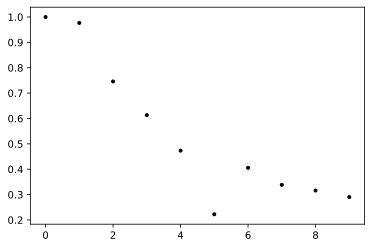

In [226]:
plt.plot(Lambda, 'k.')

In [227]:
Lambda

array([0.999714  , 0.9765412 , 0.74589753, 0.6131936 , 0.47324333,
       0.22227526, 0.4053995 , 0.33843252, 0.31598854, 0.29003188],
      dtype=float32)

In [228]:
CVs = kernel(hb_distances[::10], hb_distances[shifted_idxs], backend='keops')@W

In [229]:
scaled_CVs = (CVs - np.mean(CVs, axis=0))/np.std(CVs, axis = 0)

In [237]:
from stateinterpreter.utils.numerical_utils import gaussian_kde
def f(x):
    kde = gaussian_kde(scaled_CVs[:,x][:,np.newaxis], bandwidth=0.1)
    bounds = (scaled_CVs[:,x].min(),scaled_CVs[:,x].max())
    padding = 0
    cv_sample = np.linspace(bounds[0] - padding, bounds[1] + padding, 200)[:,np.newaxis]
    plt.plot(cv_sample, -kde.logpdf(cv_sample), 'k-')
    plt.margins(0)
    plt.xlabel(f"Kernel_DMD_{x}")
    plt.ylabel(r"Fes $[K_{\rm{B}}T]$")

In [238]:
widgets.interact(f, x=widgets.IntSlider(min=0, max=len(Lambda) - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=9), Output()), _dom_classes=('widget-interact',)…

In [232]:
descriptors, feats_info = compute_descriptors(traj[::10], descriptors=['hbonds_distances'])

Computing Hydrogen bonds distances
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]
Descriptors: (52475, 318)


In [233]:
import pandas as pd
from stateinterpreter.metastable import identify_metastable_states
from stateinterpreter.utils.plot import plot_states
col_names = [f"Kernel_DMD_{idx}" for idx in range(scaled_CVs.shape[1])]
colvars = pd.DataFrame(scaled_CVs, columns=col_names)

In [236]:
cv_list = ["Kernel_DMD_3"]#,"Kernel_DMD_1"]#, "Kernel_DMD_2"]
kBT = 2.8
bandwidth=0.1
states_labels = identify_metastable_states(colvars, cv_list, kBT, bandwidth, fes_cutoff=0.1*kBT, optimizer_kwargs={'num_init' : 50})
plot_states(colvars, states_labels, cv_list)

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 4 local minima with selected populations:
	Basin 0 -> 8244 configurations.
	Basin 1 -> 10829 configurations.
	Basin 2 -> 3082 configurations.
	Basin 3 -> 2285 configurations.


ValueError: Number of columns must be a positive integer, not 0

<Figure size 0x400 with 0 Axes>

Optimizing Lasso Estimator: 100%|██████████| 50/50 [00:00<00:00, 74.96it/s]


Accuracy: 97%
State 1:
 HB_DIST TYR1-OHs -- ASP3-OD2s
 HB_DIST TYR1-OHs -- ASP3-OD1s


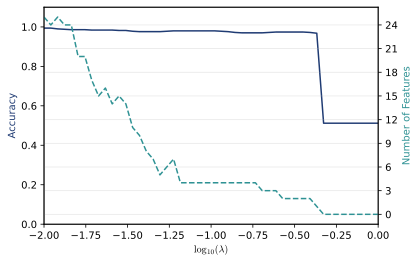

In [239]:
from stateinterpreter.ml import Classifier, prepare_training_dataset
sample_obj, features_names, classes_names = prepare_training_dataset(descriptors, states_labels, 1000, states_subset=[0,1])
regularizers = np.geomspace(0.01, 1, 50)
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000, quadratic_kernel=False)
classifier.plot();
reg = 10**(-0.5)
classifier.print_selected(reg)

In [44]:
visualize_features(traj[::stride], states_labels, classifier.classes, classifier._get_selected(reg), feats_info, state=0)

NGLWidget(max_frame=1)